In [55]:
# Импортируем необходимые библиотеки

#import os
import time

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML #, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

In [56]:
import warnings

warnings.filterwarnings('ignore')

Здесь мы устанавливаем константы для использования в ядре:

`N_THREADS`- количество vCPU для создания модели LightAutoML  
`N_FOLDS`- количество частей во внутреннем CV LightAutoML   
`TEST_SIZE`- размер части данных houldout  
`TIMEOUT`- ограничение в секундах для обучения модели  
`TARGET_NAME`- имя целевого столбца в наборе данных  

In [57]:
N_THREADS = 6
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 3600
TARGET_NAME = 'rating'

In [58]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [59]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [60]:
# загрузка исходного датасета
bgg_data = pd.read_csv('data/basic_data.csv')

In [61]:
# загрузка обработанного датасета
bgg_df = pd.read_csv('data/bgg_data_for_ml.csv')

### Подготовка данных

In [62]:
# Создадим тренировочную и валидационную выборки
df_train, df_val = train_test_split(bgg_df,
                                    test_size=TEST_SIZE,
                                    shuffle=True,
                                    random_state=RANDOM_STATE)

In [63]:
# Создадим тренировочную и валидационную выборки
data_train, data_val = train_test_split(bgg_data,
                                        test_size=TEST_SIZE,
                                        shuffle=True,
                                        random_state=RANDOM_STATE)

In [64]:
roles_df = {
    'target': TARGET_NAME
}

roles_data = {
    'target': TARGET_NAME,
    'drop': ['name', 'description']
}

In [65]:
# Функции расчета ошибки

def MAE(y_true, y_pred):
    
    abs_error = np.abs(y_pred - y_true)
    sum_abs_error = np.sum(abs_error)
    
    return sum_abs_error / y_true.size

### Обучение на обработанных данных

In [66]:
automl = TabularAutoML(
    task = Task('reg', loss = 'mae', metric = 'mae'), 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

In [67]:
%%time 
oof_pred = automl.fit_predict(df_train, roles = roles_df, verbose = 1)

[10:48:43] Stdout logging level is INFO.
[10:48:43] Task: reg

[10:48:43] Start automl preset with listed constraints:
[10:48:43] - time: 3600.00 seconds
[10:48:43] - CPU: 6 cores
[10:48:43] - memory: 16 GB

[10:48:43] Train data shape: (134805, 63)

[10:48:56] Layer 1 train process start. Time left 3586.13 secs
[10:49:09] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[10:50:00] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -1.1576228798246686
[10:50:00] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[10:50:00] Time left 3522.13 secs

[10:50:39] Selector_LightGBM fitting and predicting completed
[10:50:51] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[10:54:22] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.6927278258991545
[10:54:22] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[10:54:22] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 151.58 secs
[10:57:04] Hyperparameters optimization for Lv

In [68]:
%%time

te_pred = automl.predict(df_val)
print(f'Предсказание для тестовых данных:\n{te_pred}\nРазмер = {te_pred.shape}')

Предсказание для тестовых данных:
array([[-6.1980769e-04],
       [-2.7160289e-05],
       [ 4.7294283e+00],
       ...,
       [ 5.8732848e+00],
       [ 4.9077029e+00],
       [ 6.3726444e+00]], dtype=float32)
Размер = (33702, 1)
CPU times: total: 1min 28s
Wall time: 16 s


In [69]:
print(f'Точность модели  на тренировочных данных: {(MAE(df_train[TARGET_NAME].values, oof_pred.data[:, 0])):0.2f}')
print(f'Точность итогового предсказания: {(MAE(df_val[TARGET_NAME].values, te_pred.data[:, 0])):0.2f}')

Точность модели  на тренировочных данных: 0.68
Точность итогового предсказания: 0.67


In [70]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 


### Расчет важности признаков

In [71]:
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = Task('reg', loss = 'mae', metric = 'mae'), 
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

In [72]:
%%time
oof_pred_rd = automl_rd.fit_predict(df_train, roles=roles_df, verbose=1)

[11:19:39] Stdout logging level is INFO.
[11:19:39] Task: reg

[11:19:39] Start automl preset with listed constraints:
[11:19:39] - time: 3600.00 seconds
[11:19:39] - CPU: 6 cores
[11:19:39] - memory: 16 GB

[11:19:39] Train data shape: (134805, 63)

[11:19:49] Layer 1 train process start. Time left 3589.25 secs
[11:20:00] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[11:20:48] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -1.1577104956886781
[11:20:48] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[11:20:48] Time left 3530.35 secs

[11:21:25] Selector_LightGBM fitting and predicting completed
[11:21:37] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[11:25:03] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.6927278258991545
[11:25:03] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[11:25:03] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 166.02 secs
[11:28:20] Hyperparameters optimization for Lv

In [73]:
%%time

te_pred_rd = automl_rd.predict(df_val)
print(f'Предсказание для тестовых данных:\n{te_pred_rd}\nРазмер = {te_pred_rd.shape}')

Предсказание для тестовых данных:
array([[-6.1980769e-04],
       [-2.7160289e-05],
       [ 4.7294283e+00],
       ...,
       [ 5.8732848e+00],
       [ 4.9077029e+00],
       [ 6.3726444e+00]], dtype=float32)
Размер = (33702, 1)
CPU times: total: 1min 45s
Wall time: 22.2 s


In [74]:
print(f'Точность модели  на тренировочных данных: {(MAE(df_train[TARGET_NAME].values, oof_pred_rd.data[:, 0])):0.2f}')
print(f'Точность итогового предсказания: {(MAE(df_val[TARGET_NAME].values, te_pred_rd.data[:, 0])):0.2f}')

Точность модели  на тренировочных данных: 0.68
Точность итогового предсказания: 0.67


CPU times: total: 312 ms
Wall time: 326 ms


<AxesSubplot:xlabel='Feature'>

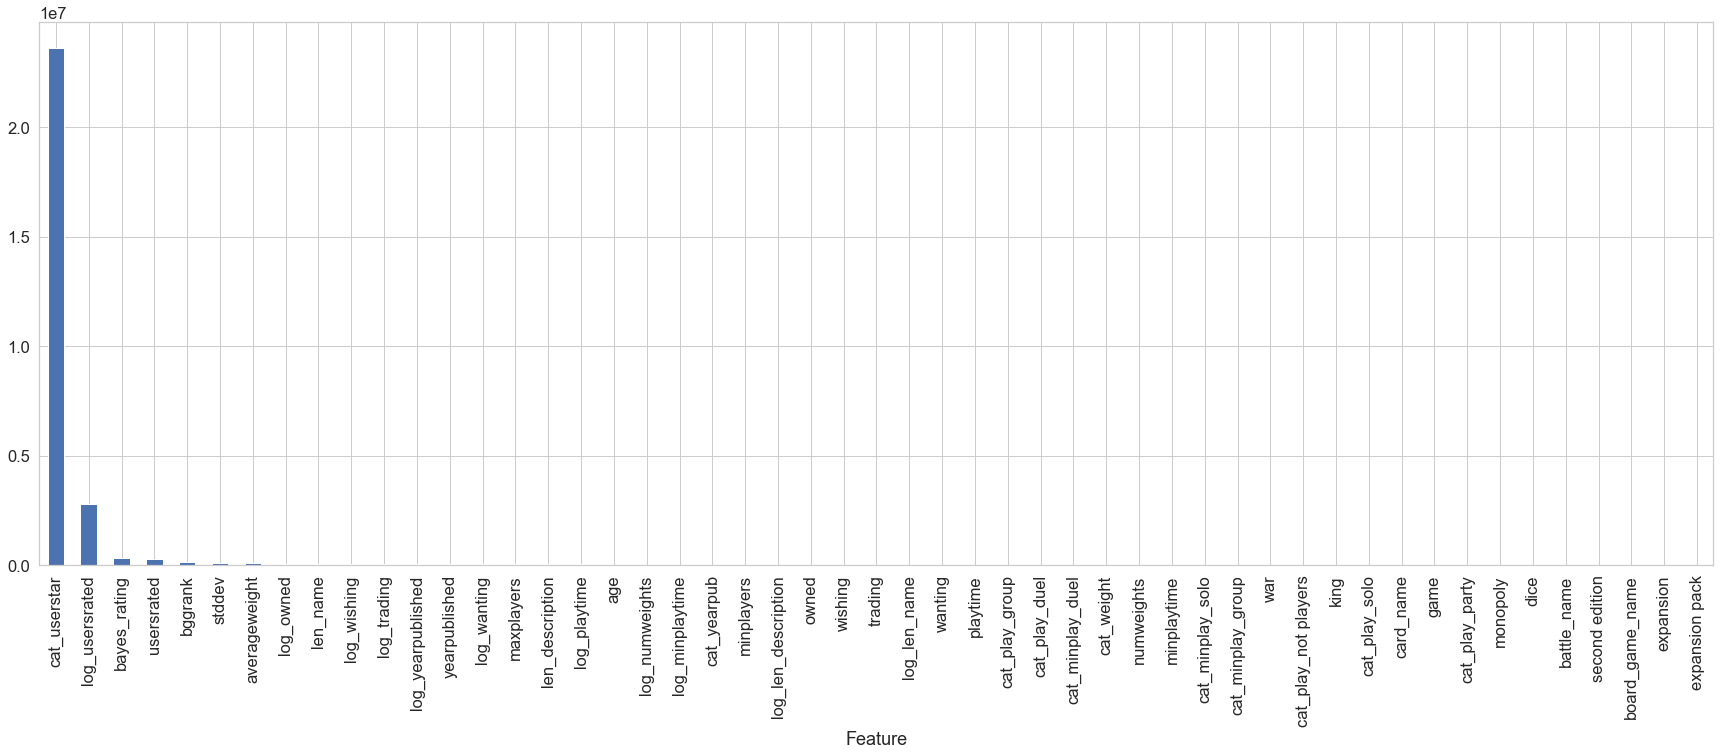

In [75]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [76]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate
accurate_fi = automl_rd.model.get_feature_scores('accurate', df_val, silent = False)

CPU times: total: 1h 18min 12s
Wall time: 14min 5s


<AxesSubplot:xlabel='Feature'>

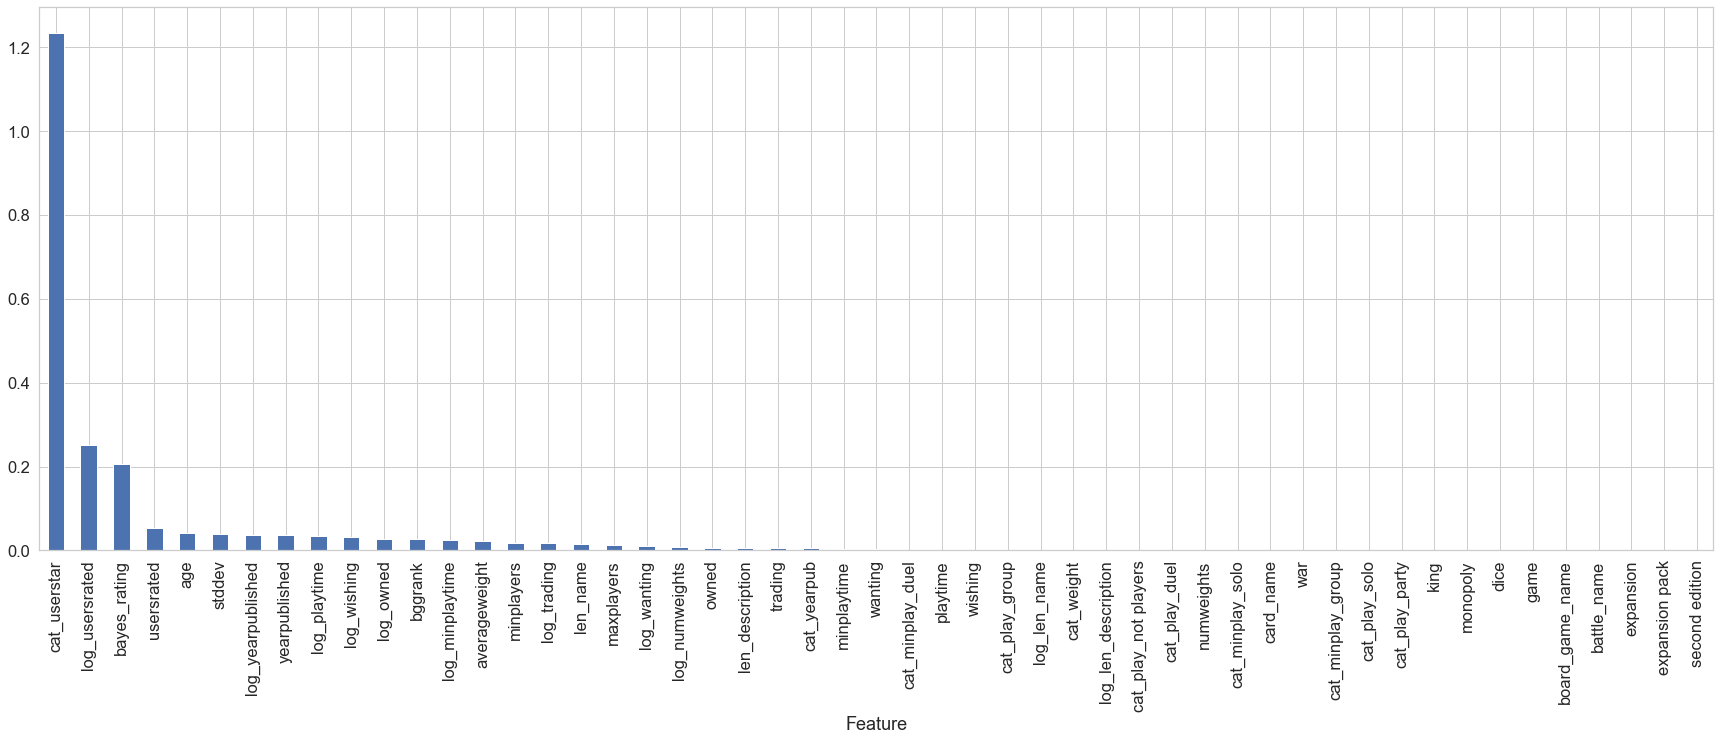

In [77]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

### Обучение на исходных данных

In [78]:
%%time 
oof_pred_data = automl.fit_predict(data_train, roles = roles_data, verbose = 1)

[12:05:54] Stdout logging level is INFO.
[12:05:54] Task: reg

[12:05:54] Start automl preset with listed constraints:
[12:05:54] - time: 3600.00 seconds
[12:05:54] - CPU: 6 cores
[12:05:54] - memory: 16 GB

[12:05:54] Train data shape: (228948, 22)

[12:06:11] Layer 1 train process start. Time left 3583.79 secs
[12:06:18] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[12:06:23] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -1.6991271792027896
[12:06:23] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[12:06:23] Time left 3570.97 secs

[12:07:05] Selector_LightGBM fitting and predicting completed
[12:07:12] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[12:10:43] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.4070815222800775
[12:10:43] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[12:10:43] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 165.38 secs
[12:14:03] Hyperparameters optimization for Lv

In [79]:
%%time

te_pred_data = automl.predict(data_val)
print(f'Предсказание для тестовых данных:\n{te_pred_data}\nРазмер = {te_pred_data.shape}')

Предсказание для тестовых данных:
array([[0.        ],
       [0.00643231],
       [6.3870993 ],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]], dtype=float32)
Размер = (57238, 1)
CPU times: total: 3min 55s
Wall time: 40.6 s


In [80]:
print(f'Точность модели  на тренировочных данных: {(MAE(data_train[TARGET_NAME].values, oof_pred_data.data[:, 0])):0.2f}')
print(f'Точность итогового предсказания: {(MAE(data_val[TARGET_NAME].values, te_pred_data.data[:, 0])):0.2f}')

Точность модели  на тренировочных данных: 0.40
Точность итогового предсказания: 0.40
